In [296]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import re


In [297]:
dos_df = pd.read_csv('/kaggle/input/car-hacking-dataset/DoS_dataset.csv')
dos_df.columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
dos_df.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [298]:
dos_df.nunique()

Timestamp    3665770
CAN ID            27
DLC                2
DATA0            108
DATA1             71
DATA2             76
DATA3             26
DATA4            190
DATA5            256
DATA6             75
DATA7            256
Flag               2
dtype: int64

In [299]:
df_2 = dos_df.copy()

In [300]:
missing_values = df_2.isnull().sum()
missing_values

Timestamp        0
CAN ID           0
DLC              0
DATA0            0
DATA1            0
DATA2            0
DATA3        31188
DATA4        31188
DATA5        31188
DATA6        31188
DATA7        31188
Flag         31188
dtype: int64

In [301]:
df_dlc_is_2 = df_2[df_2["DLC"] == 2].copy()
df_dlc_is_2.head(), df_dlc_is_2.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 35   1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 134  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 226  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 319  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 411  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 
     Flag  
 35   NaN  
 134  NaN  
 226  NaN  
 319  NaN  
 411  NaN  ,
 (31188, 12))

In [302]:
df_d2_nan = df_2[df_2["DATA2"] == 'R'].copy()
df_d2_nan.head(), df_d2_nan.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 35   1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 134  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 226  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 319  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 411  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 
     Flag  
 35   NaN  
 134  NaN  
 226  NaN  
 319  NaN  
 411  NaN  ,
 (31188, 12))

In [303]:
df_flag_nan = df_2[(df_2["Flag"] != "T") & (df_2["Flag"] != "R")]
df_flag_nan.head(10), df_flag_nan.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 35   1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 134  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 226  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 319  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 411  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 504  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 596  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 689  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 781  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 874  1.478198e+09   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN   
 
     Flag  
 35   NaN  
 134  NaN  
 226  NaN  
 319  NaN  
 411  NaN  
 504  NaN  
 596  NaN  


In [304]:
df_3 = df_2.copy()

In [305]:
# For rows with DLC=2, move 'R' from DATA2 to Flag
mask = df_3["DLC"] == 2
df_3.loc[mask, "Flag"] = df_3.loc[mask, "DATA2"]  # Copy 'R' to Flag
df_3.loc[mask, "DATA2"] = np.nan  # Set DATA2 to NaN for DLC=2



# Verify alignment
print(df_3[df_3["DLC"] == 2].head())

        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
35   1.478198e+09   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN   
134  1.478198e+09   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN   
226  1.478198e+09   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN   
319  1.478198e+09   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN   
411  1.478198e+09   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN   

    Flag  
35     R  
134    R  
226    R  
319    R  
411    R  


In [306]:
df_4 = df_3.copy()

In [307]:
# Fill NaN with hex 00
default_hex = '00'
data_columns = ['DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
df_4[data_columns] = df_4[data_columns].fillna(default_hex)
print(df_4[df_4["DLC"] == 2].head()), df_4[df_4["DLC"] == 2].shape

        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
35   1.478198e+09   05f0    2    01    00    00    00    00    00    00    00   
134  1.478198e+09   05f0    2    01    00    00    00    00    00    00    00   
226  1.478198e+09   05f0    2    01    00    00    00    00    00    00    00   
319  1.478198e+09   05f0    2    01    00    00    00    00    00    00    00   
411  1.478198e+09   05f0    2    01    00    00    00    00    00    00    00   

    Flag  
35     R  
134    R  
226    R  
319    R  
411    R  


(None, (31188, 12))

In [308]:
df_4.head(), df_4.shape

(      Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 0  1.478198e+09   018f    8    fe    5b    00    00    00    3c    00    00   
 1  1.478198e+09   0260    8    19    21    22    30    08    8e    6d    3a   
 2  1.478198e+09   02a0    8    64    00    9a    1d    97    02    bd    00   
 3  1.478198e+09   0329    8    40    bb    7f    14    11    20    00    14   
 4  1.478198e+09   0545    8    d8    00    00    8a    00    00    00    00   
 
   Flag  
 0    R  
 1    R  
 2    R  
 3    R  
 4    R  ,
 (3665770, 12))

In [309]:
df_4[(df_4["Flag"] != "T") & (df_4["Flag"] != "R")]


,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag


In [310]:
df_4[df_4["DATA2"] == 'R'].head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag


In [311]:
# Drop unnecessary columns
df_drop_dlc = df_4.drop(["DLC"], axis=1).copy()
df_drop_dlc.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,018f,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,d8,00,00,8a,00,00,00,00,R


In [312]:
df_drop_dlc.dtypes, df_drop_dlc.shape

(Timestamp    float64
 CAN ID        object
 DATA0         object
 DATA1         object
 DATA2         object
 DATA3         object
 DATA4         object
 DATA5         object
 DATA6         object
 DATA7         object
 Flag          object
 dtype: object,
 (3665770, 11))

In [313]:
df_can_id_0000 = df_drop_dlc[df_drop_dlc["CAN ID"] == "0000"]
df_can_id_0000.head(), df_can_id_0000.shape

(         Timestamp CAN ID DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7 Flag
 1475  1.478198e+09   0000    00    00    00    00    00    00    00    00    T
 1477  1.478198e+09   0000    00    00    00    00    00    00    00    00    T
 1479  1.478198e+09   0000    00    00    00    00    00    00    00    00    T
 1481  1.478198e+09   0000    00    00    00    00    00    00    00    00    T
 1483  1.478198e+09   0000    00    00    00    00    00    00    00    00    T,
 (587521, 11))

In [314]:
df_6 = df_drop_dlc.copy()
df_6.describe()

,Timestamp
count,3.665770e+06
mean,1.478200e+09
std,8.471848e+02
min,1.478198e+09
25%,1.478199e+09
50%,1.478200e+09
75%,1.478201e+09
max,1.478201e+09


In [315]:
data_columns = ['DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']

# Create regex pattern for valid hex
hex_pattern = r'^[0-9A-Fa-f]{2}$'

# Check for non-hex values
mask = df_6[data_columns].apply(lambda col: ~col.str.match(hex_pattern, na=False))

# Get rows with any invalid entries
invalid_rows = df_6[mask.any(axis=1)]

print("Rows with non-hex values in DATA columns:")
print(invalid_rows if not invalid_rows.empty else "No non-hex values found")

Rows with non-hex values in DATA columns:
No non-hex values found


In [316]:
df_7 = df_6.copy()
# Function to convert hex to decimal
def hex_to_int(hex_str: str) -> int:
    try:
        return int(str(hex_str).strip(), 16)  # Convert hex to int
    except ValueError:
        return np.nan 

# Convert all DATA columns
for col in df_7.columns[1:-1]:  # Exclude 'Flag' column
    df_7[col] = df_7[col].apply(hex_to_int)

df_7.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,399,254,91,0,0,0,60,0,0,R
1,1.478198e+09,608,25,33,34,48,8,142,109,58,R
2,1.478198e+09,672,100,0,154,29,151,2,189,0,R
3,1.478198e+09,809,64,187,127,20,17,32,0,20,R
4,1.478198e+09,1349,216,0,0,138,0,0,0,0,R


In [317]:
df_8 = df_7.copy()

In [318]:
df_8["Flag"] = df_8["Flag"].map({"R": 0, "T": 1})
df_8.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,399,254,91,0,0,0,60,0,0,0
1,1.478198e+09,608,25,33,34,48,8,142,109,58,0
2,1.478198e+09,672,100,0,154,29,151,2,189,0,0
3,1.478198e+09,809,64,187,127,20,17,32,0,20,0
4,1.478198e+09,1349,216,0,0,138,0,0,0,0,0


In [319]:
df_8["Flag"].unique()

array([0, 1])

In [320]:
df_8.isna().sum()

Timestamp    0
CAN ID       0
DATA0        0
DATA1        0
DATA2        0
DATA3        0
DATA4        0
DATA5        0
DATA6        0
DATA7        0
Flag         0
dtype: int64

In [321]:
df_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665770 entries, 0 to 3665769
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   CAN ID     int64  
 2   DATA0      int64  
 3   DATA1      int64  
 4   DATA2      int64  
 5   DATA3      int64  
 6   DATA4      int64  
 7   DATA5      int64  
 8   DATA6      int64  
 9   DATA7      int64  
 10  Flag       int64  
dtypes: float64(1), int64(10)
memory usage: 307.6 MB


In [322]:
df_8.describe()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
count,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06
mean,1.478200e+09,5.898021e+02,5.053060e+01,3.742432e+01,3.037550e+01,5.403188e+01,3.888667e+01,5.620259e+01,2.178434e+01,4.054242e+01,1.602722e-01
std,8.471848e+02,4.309473e+02,8.810461e+01,5.212957e+01,5.307059e+01,8.843757e+01,6.810672e+01,7.704030e+01,5.247999e+01,6.740078e+01,3.668584e-01
min,1.478198e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.478199e+09,3.040000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.478200e+09,6.080000e+02,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.478201e+09,8.800000e+02,3.600000e+01,3.900000e+01,3.500000e+01,4.800000e+01,3.500000e+01,1.270000e+02,9.000000e+00,5.700000e+01,0.000000e+00
max,1.478201e+09,1.680000e+03,2.550000e+02,1.920000e+02,2.520000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.090000e+02,2.550000e+02,1.000000e+00


In [323]:
# df_8.to_csv('/kaggle/working/cleaned_data.csv', index=False)

# print("Data saved successfully as 'cleaned_data.csv'.")

In [324]:
# Exclude the 'Flag' column before calculating correlation
correlation_matrix = df_8.drop(columns=['Timestamp', 'CAN ID', 'Flag']).corr()
correlation_matrix

,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7
DATA0,1.000000,0.265148,-0.084861,-0.118518,0.302947,0.162191,-0.083844,-0.158038
DATA1,0.265148,1.000000,0.248555,0.249595,0.001412,0.275357,-0.195221,0.195102
DATA2,-0.084861,0.248555,1.000000,0.149292,0.367018,-0.039111,0.308908,0.133593
DATA3,-0.118518,0.249595,0.149292,1.000000,0.144452,0.615395,0.020012,0.038851
DATA4,0.302947,0.001412,0.367018,0.144452,1.000000,0.351487,0.192900,0.019239
DATA5,0.162191,0.275357,-0.039111,0.615395,0.351487,1.000000,0.066449,-0.032675
DATA6,-0.083844,-0.195221,0.308908,0.020012,0.192900,0.066449,1.000000,-0.078964
DATA7,-0.158038,0.195102,0.133593,0.038851,0.019239,-0.032675,-0.078964,1.000000


<Axes: >

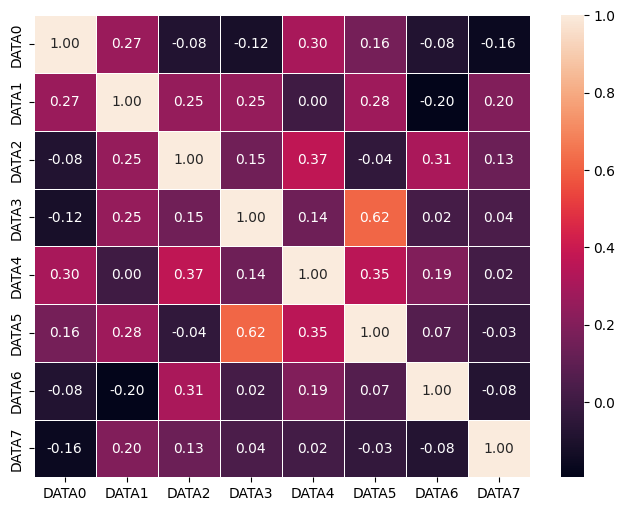

In [326]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.5)

In [327]:
df_9 = df_8.copy()
df_9.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,399,254,91,0,0,0,60,0,0,0
1,1.478198e+09,608,25,33,34,48,8,142,109,58,0
2,1.478198e+09,672,100,0,154,29,151,2,189,0,0
3,1.478198e+09,809,64,187,127,20,17,32,0,20,0
4,1.478198e+09,1349,216,0,0,138,0,0,0,0,0


# Realistic Scenario with no CAN ID included

## Algorithm Selection XGB

In [278]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# import xgboost as xgb
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
# import matplotlib.pyplot as plt

# # Load data
# df = df_9.copy()

# # 1. Preprocessing
# # Convert CAN ID to numerical (already done as 0 for attacks)
# df['CAN ID'] = df['CAN ID'].astype('int64')

# # 2. Define features and target variable
# # DROP CAN ID - IT'S A DIRECT LEAKAGE
# X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
# y = df['Flag']

# # 3. Split data with stratification
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     stratify=y, 
#     random_state=42
# )

# # 4. Initialize XGBoost with realistic parameters
# model = xgb.XGBClassifier(
#     scale_pos_weight=5.24,
#     objective='binary:logistic',
#     eval_metric='aucpr',
#     use_label_encoder=False,
#     max_depth=6,  # Prevent overfitting
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )

# # 5. Train the model
# model.fit(X_train, y_train)

# # 6. Evaluate
# y_pred = model.predict(X_test)
# y_proba = model.predict_proba(X_test)[:, 1]

# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# # 7. Feature Importance
# plt.figure(figsize=(10, 6))
# plt.title("Feature Importances (Without CAN ID Leakage)")
# xgb.plot_importance(model, ax=plt.gca())
# plt.show()

In [279]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, roc_curve, auc

# # 1. Plot Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # 2. Plot ROC Curve
# fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(6, 4))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()


In [280]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
# import xgboost as xgb

# # Load dataset
# df = df_9.copy()
# print(df.columns)


# # Define feature columns and target
# features = ['DATA0', 'DATA1', 'DATA5', 'DATA7']
# X = df[features]
# y = df['Flag']  # Target: 1 = Attack, 0 = Normal

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train XGBoost model
# model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss")
# model.fit(X_train, y_train)

# # Predictions
# y_pred = model.predict(X_test)
# y_proba = model.predict_proba(X_test)[:, 1]  # Probability scores

# # Performance Metrics
# print(classification_report(y_test, y_pred))
# roc_auc = roc_auc_score(y_test, y_proba)
# print(f"ROC AUC Score: {roc_auc:.4f}")

# # Precision-Recall Curve & Optimal Threshold
# precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
# target_recall = 0.95
# idx = np.argmax(recall >= target_recall)
# optimal_threshold = thresholds[idx]
# print(f"Optimal Decision Threshold: {optimal_threshold:.2f}")

# # Feature Importance Analysis
# plt.figure(figsize=(8, 5))
# xgb.plot_importance(model, importance_type='weight', title="Feature Importance")
# plt.show()

# # Byte-Level Analysis
# plt.figure(figsize=(12, 6))
# for i, feature in enumerate(features[:2]):  # DATA0 and DATA1
#     plt.subplot(1, 2, i + 1)
#     sns.histplot(df[df['Flag'] == 0][feature], label='Normal', color='blue', kde=True, alpha=0.6)
#     sns.histplot(df[df['Flag'] == 1][feature], label='Attack', color='red', kde=True, alpha=0.6)
#     plt.title(f"Distribution of {feature}")
#     plt.legend()

# plt.show()

# # Feature Engineering (Bitwise & Arithmetic Transformations)
# df['DATA01 XOR'] = df['DATA0'] ^ df['DATA1']
# df['DATA01 SUM'] = df['DATA0'] + df['DATA1']
# df['DATA57 XOR'] = df['DATA5'] ^ df['DATA7']

# print(df[['DATA01 XOR', 'DATA01 SUM', 'DATA57 XOR']].describe()) 

# # Train again with engineered features
# X_new = df[['DATA0', 'DATA1', 'DATA5', 'DATA7', 'DATA01 XOR', 'DATA01 SUM', 'DATA57 XOR']]
# X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
# model.fit(X_train_new, y_train)

# # Evaluate again
# y_pred_new = model.predict(X_test_new)
# print(classification_report(y_test, y_pred_new))


In [329]:
df_9.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,399,254,91,0,0,0,60,0,0,0
1,1.478198e+09,608,25,33,34,48,8,142,109,58,0
2,1.478198e+09,672,100,0,154,29,151,2,189,0,0
3,1.478198e+09,809,64,187,127,20,17,32,0,20,0
4,1.478198e+09,1349,216,0,0,138,0,0,0,0,0


## Temporal Features

<ipython-input-356-a2ed71a40253>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Time_Since_First_Message'] = (train_df.index - train_min_time).total_seconds()
<ipython-input-356-a2ed71a40253>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Time_Since_First_Message'] = (test_df.index - train_min_time).total_seconds()


Accuracy: 1.0
Confusion Matrix:
 [[733154]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    733154

    accuracy                           1.00    733154
   macro avg       1.00      1.00      1.00    733154
weighted avg       1.00      1.00      1.00    733154


ROC AUC Score cannot be computed because only one class is present in the test set.

Feature Importances:
                      Feature  Importance
5                      DATA5    0.556375
0                      DATA0    0.279469
1                      DATA1    0.076982
6                      DATA6    0.035665
3                      DATA3    0.030493
7                      DATA7    0.015384
2                      DATA2    0.002204
9      Rolling_Count_DoS_1ms    0.001099
8          Global_Time_Delta    0.000955
10    Rolling_Count_DoS_10ms    0.000663
12  Time_Since_First_Message    0.000433
4                      DATA4    0.000255
11                

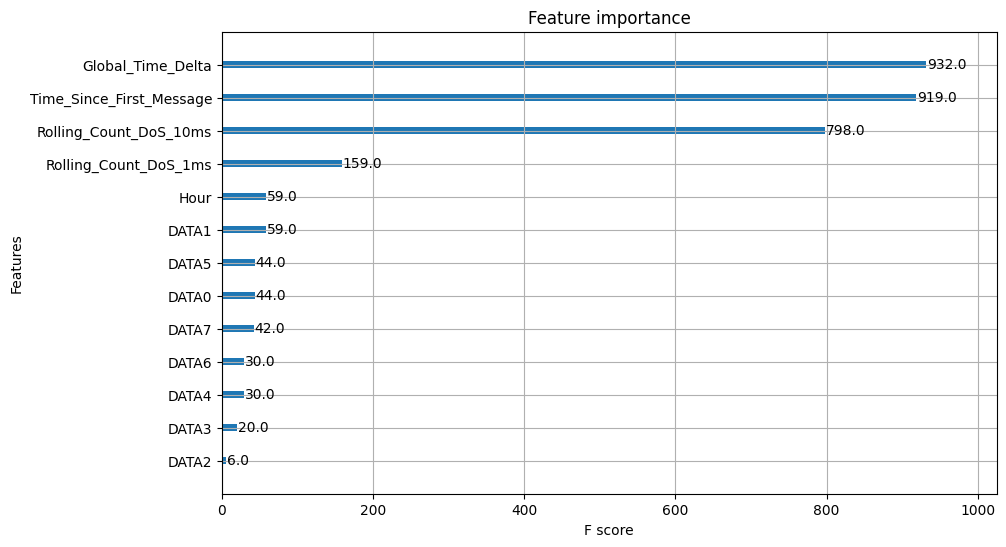

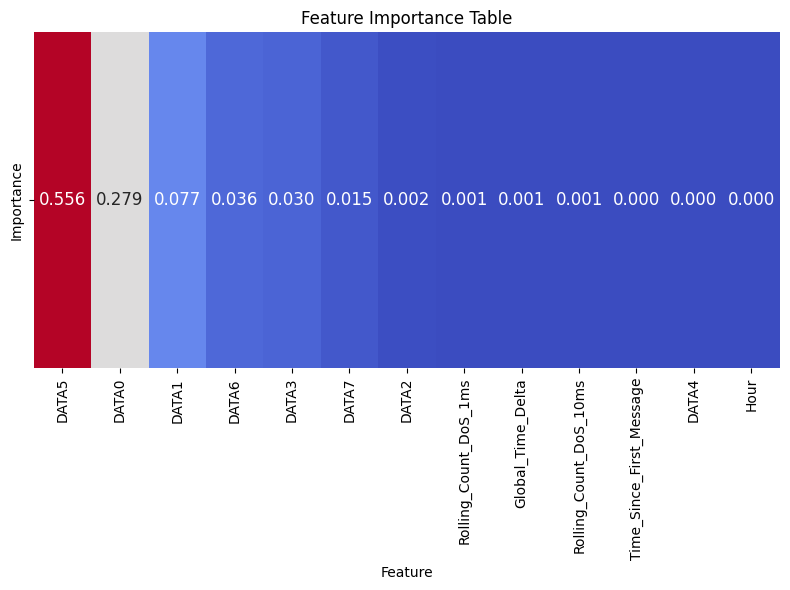

In [356]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  # Import for oversampling
from sklearn.metrics import roc_auc_score

# Load data
df = df_9.copy()

# Ensure Timestamp is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')  # Adjust unit if needed

# Sort values by Timestamp and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

# Set 'Timestamp' as the index for rolling operations
df.set_index('Timestamp', inplace=True)

# 2. Global time-based features (no ECU grouping)
df['Global_Time_Delta'] = df.index.to_series().diff().dt.total_seconds().fillna(0)  # Time between ALL messages

# 3. Rolling count of messages in 1s and 5s window
df['Rolling_Count_DoS_1ms'] = df.rolling('1ms').count()['CAN ID']
df['Rolling_Count_DoS_10ms'] = df.rolling('10ms').count()['CAN ID']

# 4. Frequency-based features (DoS Attack detection)
df['Rolling_Count_DoS_1ms'] = df.rolling('0.3ms').count()['CAN ID']  # Messages in 0.3ms window (for DoS attack)

# 5. Frequency/Time features
df['Hour'] = df.index.hour
df['Time_Since_First_Message'] = (df.index - df.index.min()).total_seconds()

# 6. Prepare features (drop the identifier columns but don't drop 'Timestamp' since it's the index)
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Keep 'Is_DoS_Attack'
y = df['Flag']

# Split data chronologically first
train_size = int(0.8 * len(df))
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Replace train_test_split with chronological split
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Calculate time since first message using TRAINING data's min timestamp
train_min_time = train_df.index.min()
train_df['Time_Since_First_Message'] = (train_df.index - train_min_time).total_seconds()
test_df['Time_Since_First_Message'] = (test_df.index - train_min_time).total_seconds()

# 1. Apply SMOTE for oversampling to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 2. Initialize XGBoost with realistic parameters and scale_pos_weight
model = xgb.XGBClassifier(
    scale_pos_weight=10,  # Adjusting to 10
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    max_depth=6,  # Prevent overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 3. Train the model on resampled data
model.fit(X_train_res, y_train_res)

# 4. Evaluate the model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# 5. Check if both classes are present in y_test before calculating ROC AUC score
if len(np.unique(y_test)) > 1:
    print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
else:
    print("\nROC AUC Score cannot be computed because only one class is present in the test set.")

# 6. Feature Importance
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances alongside the feature names
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importance table
print("\nFeature Importances:\n", feature_importance_df)

# 7. Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Including DoS Attack Detection)")
xgb.plot_importance(model, ax=plt.gca())
plt.show()

# 8. Display the Feature Importance Table using a heatmap (for better visualization)
plt.figure(figsize=(8, 6))
sns.heatmap(feature_importance_df.set_index('Feature').T, annot=True, cmap='coolwarm', cbar=False, fmt='.3f', annot_kws={'size': 12})
plt.title('Feature Importance Table')
plt.tight_layout()
plt.show()


## Cross-Validation:

In [349]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc_scores.append(roc_auc_score(y_test, y_proba))

print("Mean AUC score across folds: ", np.mean(auc_scores))


Mean AUC score across folds:  0.9998344370407232


## Visualize the Model's Predictions:

[[515617 100032]
 [ 98429  19076]]


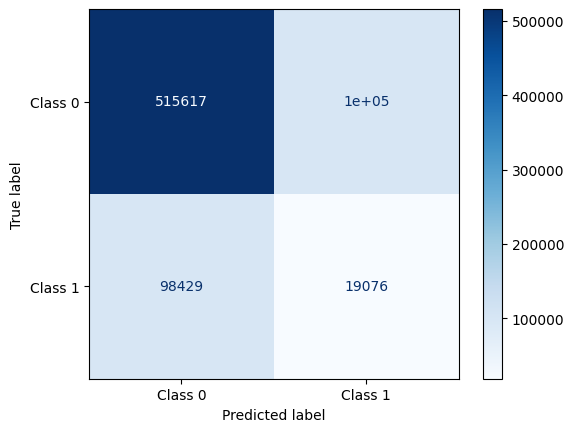

In [350]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

# Plot the confusion matrix
disp.plot(cmap='Blues')
plt.show()



The confusion matrix represents the performance of your classification model, and it looks like this:

```
cm = [[516988  98661]
 [ 98662  18843]]
```

Here's how to interpret it:

- **True Positives (TP)**: The number of instances correctly predicted as **Class 1** (attack).
  - **18843** (bottom-right cell)
  
- **False Positives (FP)**: The number of instances incorrectly predicted as **Class 1** when they are actually **Class 0** (normal).
  - **98661** (top-right cell)

- **True Negatives (TN)**: The number of instances correctly predicted as **Class 0** (normal).
  - **516988** (top-left cell)

- **False Negatives (FN)**: The number of instances incorrectly predicted as **Class 0** when they are actually **Class 1**.
  - **98662** (bottom-left cell)

### Now, let's compute some key metrics:

1. **Accuracy**: The overall percentage of correct predictions.
   \[
   \text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}
   \]
   \[
   \text{Accuracy} = \frac{18843 + 516988}{18843 + 98661 + 516988 + 98662} = \frac{535831}{733154} \approx 0.7328
   \]
   **Accuracy ≈ 73.28%**

2. **Precision for Class 1 (attack)**: The percentage of predicted positive instances (Class 1) that are actually positive.
   \[
   \text{Precision (Class 1)} = \frac{TP}{TP + FP} = \frac{18843}{18843 + 98661} \approx 0.160
   \]
   **Precision (Class 1) ≈ 16%**

3. **Recall for Class 1 (attack)**: The percentage of actual positive instances (Class 1) that were correctly identified.
   \[
   \text{Recall (Class 1)} = \frac{TP}{TP + FN} = \frac{18843}{18843 + 98662} \approx 0.160
   \]
   **Recall (Class 1) ≈ 16%**

4. **F1 Score for Class 1**: The harmonic mean of precision and recall.
   \[
   \text{F1 Score (Class 1)} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \approx 2 \times \frac{0.160 \times 0.160}{0.160 + 0.160} \approx 0.160
   \]
   **F1 Score (Class 1) ≈ 16%**

5. **Precision for Class 0 (normal)**: The percentage of predicted negative instances (Class 0) that are actually negative.
   \[
   \text{Precision (Class 0)} = \frac{TN}{TN + FN} = \frac{516988}{516988 + 98662} \approx 0.839
   \]
   **Precision (Class 0) ≈ 84%**

6. **Recall for Class 0 (normal)**: The percentage of actual negative instances (Class 0) that were correctly identified.
   \[
   \text{Recall (Class 0)} = \frac{TN}{TN + FP} = \frac{516988}{516988 + 98661} \approx 0.840
   \]
   **Recall (Class 0) ≈ 84%**

7. **F1 Score for Class 0**: The harmonic mean of precision and recall for Class 0.
   \[
   \text{F1 Score (Class 0)} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \approx 2 \times \frac{0.839 \times 0.840}{0.839 + 0.840} \approx 0.839
   \]
   **F1 Score (Class 0) ≈ 84%**

### Conclusion:
- **Accuracy**: 73.28%, which suggests that the model is correct approximately 73% of the time.
- **For Class 1 (attack)**: The model has low **precision** and **recall** (~16%), meaning it's not identifying attack instances very well.
- **For Class 0 (normal)**: The model performs better for Class 0, with an **accuracy** of ~84%, and a much higher **precision** and **recall** (~84%).
  
This could indicate an imbalance between the two classes, with the model biased towards predicting the **normal** class (Class 0). A higher number of **False Negatives (98662)** and **False Positives (98661)** for the attack class (Class 1) suggests that the model is not very effective in detecting attacks. To improve the model's performance for **Class 1**, techniques like **resampling** (e.g., SMOTE), adjusting class weights, or using specialized algorithms for imbalanced data might be helpful.

## Hyperparameter Tuning using GridSearchCV

In [132]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
                           param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'subsample': 0.8}


## Algorithm RF

Accuracy: 0.9766351953341317
Confusion Matrix:
 [[598520  17130]
 [     0 117504]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    615650
           1       0.87      1.00      0.93    117504

    accuracy                           0.98    733154
   macro avg       0.94      0.99      0.96    733154
weighted avg       0.98      0.98      0.98    733154


ROC AUC Score: 0.9861


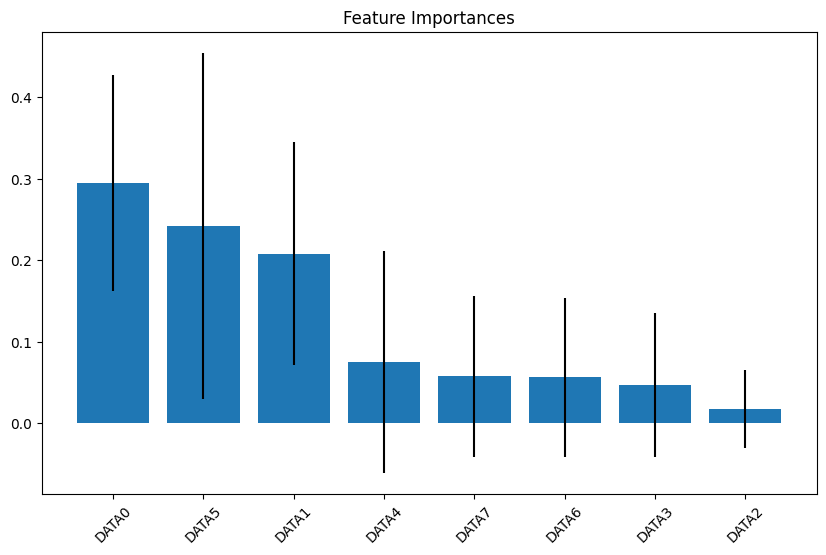

In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()

# 2. Split data
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Initialize Random Forest with class weighting
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Handles imbalance
    max_depth=10,             # Prevent overfitting
    n_jobs=-1,                # Use all cores
    random_state=42
)

# 4. Train model
rf.fit(X_train, y_train)

# 5. Evaluate
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 6. Feature Importance
features = X.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create DataFrame
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances, 'Std': std})
fi_df = fi_df.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(fi_df['Feature'], fi_df['Importance'], yerr=fi_df['Std'])
plt.xticks(rotation=45)
plt.show()

## Class Weight Tuning

Accuracy: 0.9766351953341317
Confusion Matrix:
 [[598520  17130]
 [     0 117504]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    615650
           1       0.87      1.00      0.93    117504

    accuracy                           0.98    733154
   macro avg       0.94      0.99      0.96    733154
weighted avg       0.98      0.98      0.98    733154


ROC AUC Score: 0.9861


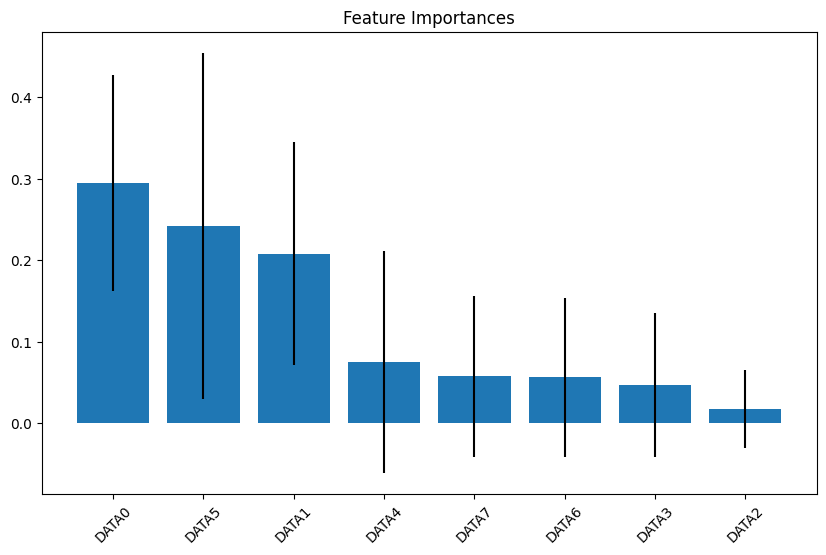

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()


# 2. Split data
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Manually calculate class weights based on the exact class ratio (~5.24:1)
ratio = 3_078_250 / 587_521  # approximately 5.24
class_weights = {0: 1, 1: ratio}  # Assign higher weight to minority class

# 4. Initialize Random Forest with manually calculated class weights
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,  # using manual weights instead of 'balanced'
    max_depth=10,                # Prevent overfitting
    n_jobs=-1,                   # Use all available cores
    random_state=42
)

# 5. Train the model
rf.fit(X_train, y_train)

# 6. Evaluate the model
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Feature Importance
features = X.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create DataFrame for feature importances
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances, 'Std': std})
fi_df = fi_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(fi_df['Feature'], fi_df['Importance'], yerr=fi_df['Std'])
plt.xticks(rotation=45)
plt.show()


## Threshold Adjustment

Optimal Threshold (based on maximum F1): 0.9726
Accuracy: 0.9766351953341317
Confusion Matrix:
 [[598520  17130]
 [     0 117504]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    615650
           1       0.87      1.00      0.93    117504

    accuracy                           0.98    733154
   macro avg       0.94      0.99      0.96    733154
weighted avg       0.98      0.98      0.98    733154


ROC AUC Score: 0.9861


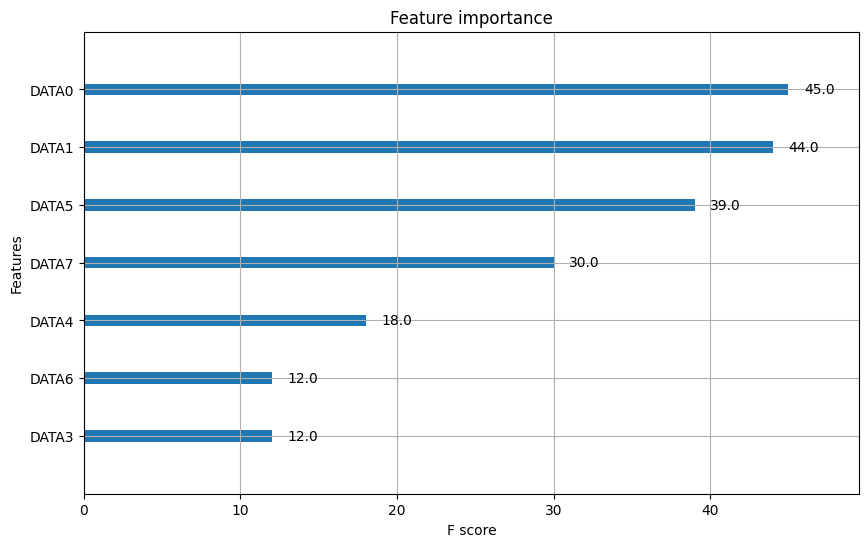

In [115]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()


X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# 3. Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 4. Initialize XGBoost classifier with built-in imbalance handling
model = xgb.XGBClassifier(
    scale_pos_weight=5.24,      # Directly accounts for the class imbalance ratio
    objective='binary:logistic',
    eval_metric='aucpr',        # Optimize for precision-recall AUC
    use_label_encoder=False,    # Suppress a warning regarding label encoding
    random_state=42
)

# 5. Train the model
model.fit(X_train, y_train)

# 6. Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# 7. Threshold Adjustment: Optimize decision threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for each threshold; note that thresholds array is one element shorter than precision/recall
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # avoid division by zero
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal Threshold (based on maximum F1): {best_threshold:.4f}")

# Use the optimal threshold to make final predictions
y_pred = (y_proba >= best_threshold).astype(int)

# 8. Evaluate the model with the adjusted threshold
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 9. Feature Importance Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (XGBoost)")
xgb.plot_importance(model, ax=plt.gca())
plt.show()


## Hyperparameter Tuning:

In [130]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_rf.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_tuned))


# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [50, 100, 200]
# }

# grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
#                            param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print("Best parameters:", grid_search.best_params_)


KeyboardInterrupt: 

2. **Advanced Handling of CAN ID**:

In [ ]:
   # Create interaction features between CAN ID and data bytes
   df['CAN_ID_Interaction'] = df['CAN ID'].astype(str) + '_' + df['DATA0'].astype(str)

3. **Dimensionality Reduction**:

In [ ]:
 from sklearn.decomposition import PCA
   
   pca = PCA(n_components=5)
   X_pca = pca.fit_transform(X)